# Pytorch 4. 训练神经网络 (Training our Neural Network)

在上一个教程中，我们为我们的神经网络创建了代码。在这个使用 Python 和 Pytorch 进行深度学习的教程中，我们将通过学习如何迭代我们的数据、传递给模型、从结果中计算损失，然后进行反向传播以使我们的模型慢慢适应数据。

在之前的文章中，我们已经完成以下部分的代码：


In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))


trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


## 1. 反向传播

### 1.1 优化器(optimizer)

对我们来说幸运的是， Pytorch 使用的“数据”实际上已经分批了，我们只需要迭代它。接下来，我们要计算损失并指定我们的优化器：

In [3]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### 1.2 损失函数(loss_function)

损失函数 `loss_function` 用于计算我们的分类与现实的之间的差距。作为人类，我们倾向于根据对或错来思考事物。但神经网络，则是已经一件事物的可能性来判断事情。就机器学习而言，为了使得模型准确，需要通过调整大量的参数以逐渐接近拟合。为此，我们使用损失`loss`，这是衡量神经网络与目标输出的距离。损失计算的方法有很多种。一种比较流行的方法是使用均方误差。

$$
MSE = \frac{\sum_{i=1}^n(y_i - \hat{y}_i)^2}{N}
$$

由于我们的例子是一个分类问题，因此这里我们使用的损失函数是 `nll_loss`

对于数据类别的表示方式一般有两种，一种是标量式，另外一种是 `one_hot vector` 向量式，比如：

$$
0 \\ or \\
\begin{bmatrix}
    1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix}
$$

`one_hot vector` 是一个二进制的向量，其中的每一个元素都是 0 或 1，比如：3 可以表示为：

$$
\begin{bmatrix}
    0 & 0 & 0 & 3 & 0 & 0 & 0 & 0\\
\end{bmatrix}
$$

接下来，我们需要一个优化器，这里我们使用的是 `Adam` 优化器，它是一种比较流行的优化器。`Adam` 可以自适应动量和梯度，这样可以避免梯度爆炸的问题。在将这个之前，我们先来了解一下学习率 `learning_rate`，这是一个可以调整的参数，它决定了模型学习的速度。过快会出现反复横跳，过慢训练时间就会很长。

![ ](./pics/leanring.jpg)

通常来说，我们希望学习率先大后小，这样可以帮助我们的模型快速找到最优解附近，然后在该点位附近慢慢的找到最优点。



### 1.3 时期 (epoch)

现在我们可以迭代我们的数据。通常，您将不止一次通过整个训练数据集。数据集的每一次完整传递都称为一个时期 (`epoch`)。一般来说，你可能会有 3 到 10 个 `epoch` ，但这里没有硬性规定。时期太少，模型不会学习完所有的数据。时期太多，模型可能会过度拟合您的样本内数据（基本上记住样本内数据，但在样本外数据上表现不佳）。

现在让我们使用 3 个 `epoch` 。所以我们将循环遍历 `epoch` ，每个 `epoch` 都会遍历我们的数据。就像是：

In [4]:
for epoch in range(3): # 3 full passes over the data
    for data in trainset:  # `data` is a batch of data
        X, y = data  # X is the batch of features, y is the batch of targets.
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(X.view(-1,784))  # pass in the reshaped batch (recall they are 28x28 atm)
        loss = F.nll_loss(output, y)  # calc and grab the loss value
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    print(loss)  # print loss. We hope loss (a measure of wrong-ness) declines! 

tensor(0.0348, grad_fn=<NllLossBackward0>)
tensor(0.0033, grad_fn=<NllLossBackward0>)
tensor(0.1283, grad_fn=<NllLossBackward0>)


### 1.4 总结

在上面的代码中，有一行 `net.zero_grad()` 在每一批次数据通过之后，将梯度设置为零，下一批次的数据将在之前已经优化过的模型上，从新开始梯度下降。下面我们来总结一下在一个批次中，我们让神经网络做了什么：

- 从当前批次中获取特征 (X) 和标签 (y)
- 将梯度归零 (net.zero_grad)
- 通过网络传递数据
- 计算损失
- 调整网络中的权重以减少损失

## 2. 验证模型

当我们迭代时，我们会得到损失值，这是一个重要的指标，但我们关心的是准确性。那么，我们是怎么做的呢？为了测试这一点，我们需要做的就是迭代我们的测试集，通过将输出与目标值进行比较来测量正确性。

In [5]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1,784))
        #print(output)
        for idx, i in enumerate(output):
            #print(torch.argmax(i), y[idx])
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.967


结果看起来还不错，准确率达到了 0.967。光有准确率还不够直观，下面我们将图片和结果打印出来，看一下结果是否正确：

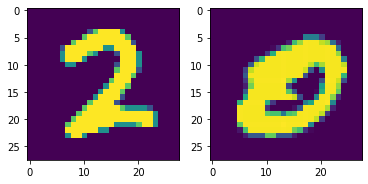

tensor(2)
tensor(0)


In [19]:
import matplotlib.pyplot as plt

# randomly select a few images from the test set and plot them
plt.subplot(1,2,1)
plt.imshow(X[5].view(28,28))

plt.subplot(1,2,2)
plt.imshow(X[3].view(28,28))
plt.show()

print(torch.argmax(net(X[5].view(-1,784))[0]))
print(torch.argmax(net(X[3].view(-1,784))[0]))

In [21]:
a_featureset = X[0]
reshaped_for_network = a_featureset.view(-1,784) # 784 b/c 28*28 image resolution.
output = net(reshaped_for_network) #output will be a list of network predictions.
first_pred = output[0]
print(first_pred)

tensor([-2.5393e+01, -1.7943e+01, -1.1810e+01, -1.5074e+01, -2.7140e+01,
        -2.0390e+01, -3.6855e+01, -7.7486e-06, -2.1229e+01, -1.8540e+01],
       grad_fn=<SelectBackward0>)


哪个指标值最大？我们使用 `argmax` 来找到这个：

In [22]:
biggest_index = torch.argmax(first_pred)
print(biggest_index)

tensor(7)
